In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("poster")

%matplotlib inline

In [8]:
colnames = ["chr", "start", "end", "period", "unit"]
df_strs = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides.bed", sep="\t", header=None, names=colnames)
    .assign(str_id = lambda x: [f"{i}_{j}" for i, j in zip(x["chr"], x["start"])])
)
df_strs

,chr,start,end,period,unit,str_id
0,chr1,14069,14081,4,CCTC,chr1_14069
1,chr1,16619,16631,3,GCT,chr1_16619
2,chr1,22811,22821,5,AGGAA,chr1_22811
3,chr1,26453,26465,2,GT,chr1_26453
4,chr1,28588,28603,1,T,chr1_28588
...,...,...,...,...,...,...
1733641,chrY,57188867,57188878,1,A,chrY_57188867
1733642,chrY,57200837,57200851,1,A,chrY_57200837
1733643,chrY,57200999,57201019,1,A,chrY_57200999
1733644,chrY,57202380,57202403,1,A,chrY_57202380


In [70]:
df_LMO = pd.read_csv("../../data/CRC/variants/CRC0282LMO-0-B_constrain.csv.gz")
df_01_0 = pd.read_csv("../../data/CRC/variants/CRC0282-01-0_constrain.csv.gz")
df_05_0 = pd.read_csv("../../data/CRC/variants/CRC0282-05-0_constrain.csv.gz")
df_07_0 = pd.read_csv("../../data/CRC/variants/CRC0282-07-0_constrain.csv.gz")

sample_dict = {
    "df_LMO": df_LMO, 
    "df_01_0": df_01_0, 
    "df_05_0": df_05_0, 
    "df_07_0": df_07_0,
}

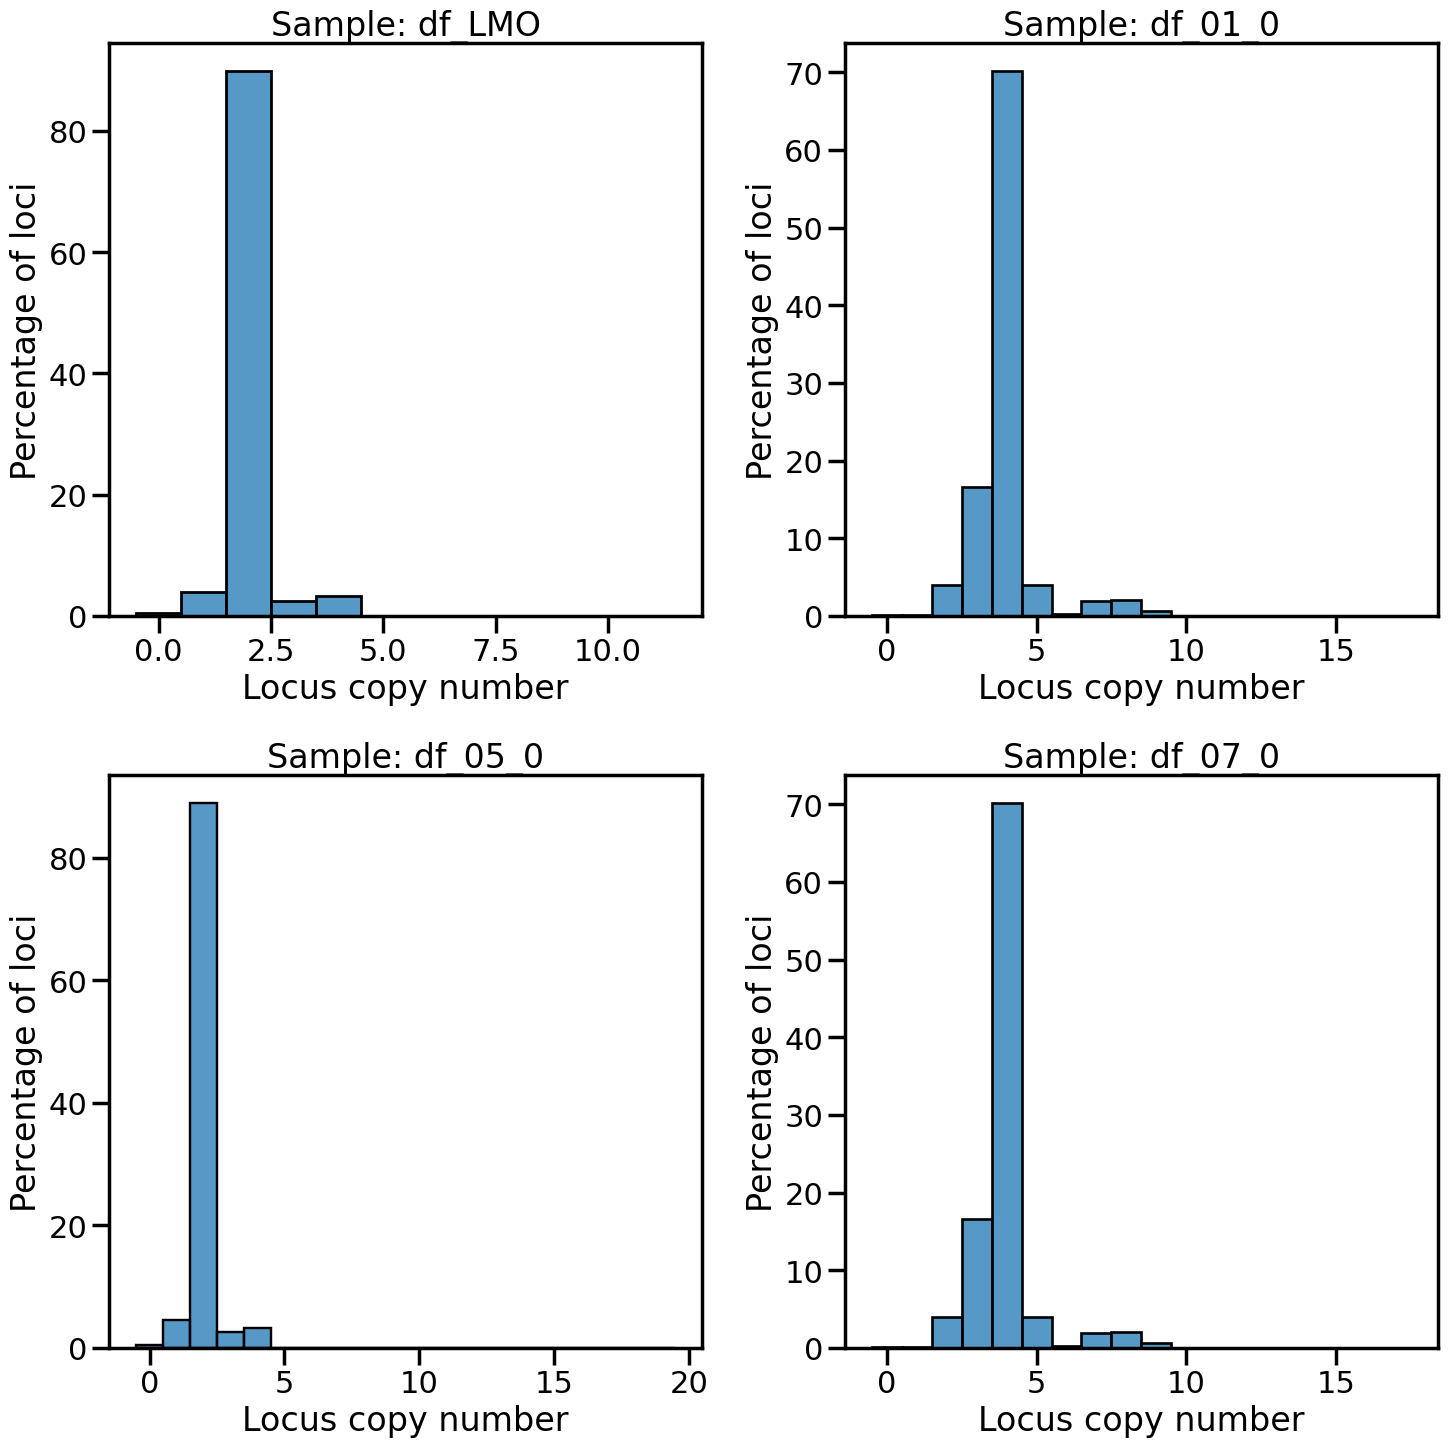

In [123]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))

for k, ax in zip(sample_dict.keys(), axes.ravel()):
    ax = sns.histplot(
        data=sample_dict[k],
        x="copy_number",
        discrete=True,
        stat="percent",
        ax=ax
    )

    ax.set(
        title=f"Sample: {k}",
        xlabel="Locus copy number",
        ylabel="Percentage of loci"
    )

plt.tight_layout()

In [41]:
# sample: (lower, upper)
filter_bounds = {
    "df_LMO": (5.5, 26.5), 
    "df_01_0": (2+(8/9), 13+(1/3)),
    "df_05_0": (5.5, 26.0),
    "df_07_0": (2.5, 13.5),
}

def depth_norm_filter(df, bounds):
    return df.query(f"depth_norm >= {bounds[0]} and depth_norm <= {bounds[1]}").reset_index(drop=True)

In [80]:
df_LMO_filt = depth_norm_filter(df_LMO, filter_bounds["df_LMO"]).dropna().reset_index(drop=True)
df_LMO_filt["copy_number"] = df_LMO_filt["copy_number"].astype(np.int64)
print("LMO:", df_LMO.shape[0], df_LMO_filt.shape[0])

df_01_0_filt = depth_norm_filter(df_01_0, filter_bounds["df_01_0"]).dropna().reset_index(drop=True)
df_01_0_filt["copy_number"] = df_01_0_filt["copy_number"].astype(np.int64)
print("01_0:", df_01_0.shape[0], df_01_0_filt.shape[0])

df_05_0_filt = depth_norm_filter(df_05_0, filter_bounds["df_05_0"]).dropna().reset_index(drop=True)
df_05_0_filt["copy_number"] = df_05_0_filt["copy_number"].astype(np.int64)
print("05_0:", df_05_0.shape[0], df_05_0_filt.shape[0])

df_07_0_filt = depth_norm_filter(df_07_0, filter_bounds["df_07_0"]).dropna().reset_index(drop=True)
df_07_0_filt["copy_number"] = df_07_0_filt["copy_number"].astype(np.int64)
print("07_0:", df_07_0.shape[0], df_07_0_filt.shape[0])


LMO: 1733646 1620915
01_0: 1733646 1611859
05_0: 1733646 1636565
07_0: 1733646 1609659


## 2n samples comparison

In [229]:
def find_new_alleles(df, suffixes):
    left, right = suffixes
    match = np.full(df.shape[0], False)
    new_gt_allele = np.full(df.shape[0], False)
    unobserved_gt_allele = np.full(df.shape[0], False)
    for i, j in df.iterrows():
        if j[f"genotype{left}"] == j[f"genotype{right}"]:
            match[i] = True
            continue
        diff = set(j[f"genotype{left}"]).symmetric_difference(j[f"genotype{right}"])
        if len(diff) == 0:
            continue
        new_gt_allele[i] = True
        if len(diff.intersection(j[f"frequencies{left}"])) == 0 or len(diff.intersection(j[f"frequencies{right}"])) == 0:
            unobserved_gt_allele[i] = True

    return match, new_gt_allele, unobserved_gt_allele

In [225]:
df_comp_2n = (df_LMO_filt
             .merge(df_05_0_filt,
                    on=["str_id", "copy_number"],
                    suffixes=("_LMO", "_05_0"),
                    how="inner")
             .merge(df_strs[["str_id", "period", "unit"]], on="str_id"))
df_comp_2n

,str_id,copy_number,frequencies_LMO,genotype_LMO,depth_LMO,depth_norm_LMO,frequencies_05_0,genotype_05_0,depth_05_0,depth_norm_05_0,period,unit
0,chr1_262683,3,"{8: 2, 9: 39, 10: 3, 11: 19, 12: 2}","[9, 9, 11]",65,21.666667,"{8: 1, 9: 30, 10: 5, 11: 26, 12: 1}","[9, 9, 11]",63,21.000000,1,T
1,chr1_263224,3,{3: 48},"[3, 3, 3]",48,16.000000,{3: 47},"[3, 3, 3]",47,15.666667,4,AAAG
2,chr1_278669,3,{3: 57},"[3, 3, 3]",57,19.000000,{3: 68},"[3, 3, 3]",68,22.666667,4,AAAT
3,chr1_279524,3,"{10: 36, 11: 2}","[10, 10, 10]",38,12.666667,{10: 28},"[10, 10, 10]",28,9.333333,1,T
4,chr1_287499,3,"{10: 32, 11: 1}","[10, 10, 10]",33,11.000000,"{10: 40, 11: 6}","[10, 10, 10]",46,15.333333,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...
1502088,chrY_11284111,2,{3: 26},"[3, 3]",26,13.000000,{3: 18},"[3, 3]",18,9.000000,5,CAAAA
1502089,chrY_11332199,2,{3: 24},"[3, 3]",24,12.000000,{3: 23},"[3, 3]",23,11.500000,4,GCTG
1502090,chrY_11455729,2,"{13: 5, 14: 17, 15: 13, 16: 3}","[14, 15]",38,19.000000,"{13: 3, 14: 10, 15: 17, 16: 2}","[14, 15]",32,16.000000,1,A
1502091,chrY_11456312,2,"{16: 2, 17: 9, 19: 2, 21: 2, 22: 6, 23: 4, 24: 1}","[17, 22]",26,13.000000,"{16: 1, 17: 1, 18: 1, 21: 2, 22: 6, 23: 6}","[22, 23]",17,8.500000,1,T


In [230]:
match, new, unobs = find_new_alleles(df_comp_2n, ("_LMO", "_05_0"))
df_comp_2n["match"] = match
df_comp_2n["new_allele"] = new
df_comp_2n["unobserved_allele"] = unobs
df_comp_2n

In [269]:
print(df_comp_2n.value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp_2n.query("not match").value_counts(["new_allele"], normalize=True))
print()
print(df_comp_2n.query("new_allele").value_counts(["unobserved_allele"], normalize=True))

match  new_allele  unobserved_allele
True   False       False                0.903538
False  True        False                0.084862
       False       False                0.007882
       True        True                 0.003717
Name: proportion, dtype: float64

new_allele
True          0.918286
False         0.081714
Name: proportion, dtype: float64

unobserved_allele
False                0.958032
True                 0.041968
Name: proportion, dtype: float64


In [314]:
print(df_comp_2n.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp_2n.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp_2n.query("period > 2 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))


match  new_allele  unobserved_allele
True   False       False                0.830083
False  True        False                0.149705
       False       False                0.014138
       True        True                 0.006074
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.971559
False  True        False                0.024409
       False       False                0.002457
       True        True                 0.001576
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.998240
False  True        False                0.001471
       False       False                0.000176
       True        True                 0.000112
Name: proportion, dtype: float64


In [318]:
print(df_comp_2n.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10").shape)
p1 = df_comp_2n.query(
    "period == 1 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)

print(df_comp_2n.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10").shape)
p2 = df_comp_2n.query(
    "period == 2 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)

print(df_comp_2n.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_05_0 >= 5").shape)
p3_6 = df_comp_2n.query(
    "period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_05_0 >= 5"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)


(751285, 15)
(74891, 15)
(610546, 15)


In [319]:
df_plot = pd.concat([
    pd.DataFrame(p1).reset_index().assign(period = "1"), 
    pd.DataFrame(p2).reset_index().assign(period = "2"), 
    pd.DataFrame(p3_6).reset_index().assign(period = "3-6")
])

genotype_match = []
for i, j in df_plot.iterrows():
    if j["match"]:
        genotype_match.append("match")
        continue    
    elif j["unobserved_allele"]:
        genotype_match.append("unobserved_allele")
        continue
    elif j["new_allele"]:
        genotype_match.append("new_allele")
        continue
    genotype_match.append("allele_shift")
genotype_match = pd.Categorical(genotype_match, categories=["match", "allele_shift", "new_allele", "unobserved_allele"], ordered=True)
df_plot["genotype_match"] = genotype_match

df_plot

,match,new_allele,unobserved_allele,proportion,period,genotype_match
0,True,False,False,0.830083,1,match
1,False,True,False,0.149705,1,new_allele
2,False,False,False,0.014138,1,allele_shift
3,False,True,True,0.006074,1,unobserved_allele
0,True,False,False,0.971559,2,match
1,False,True,False,0.024409,2,new_allele
2,False,False,False,0.002457,2,allele_shift
3,False,True,True,0.001576,2,unobserved_allele
0,True,False,False,0.997338,3-6,match
1,False,True,False,0.002216,3-6,new_allele


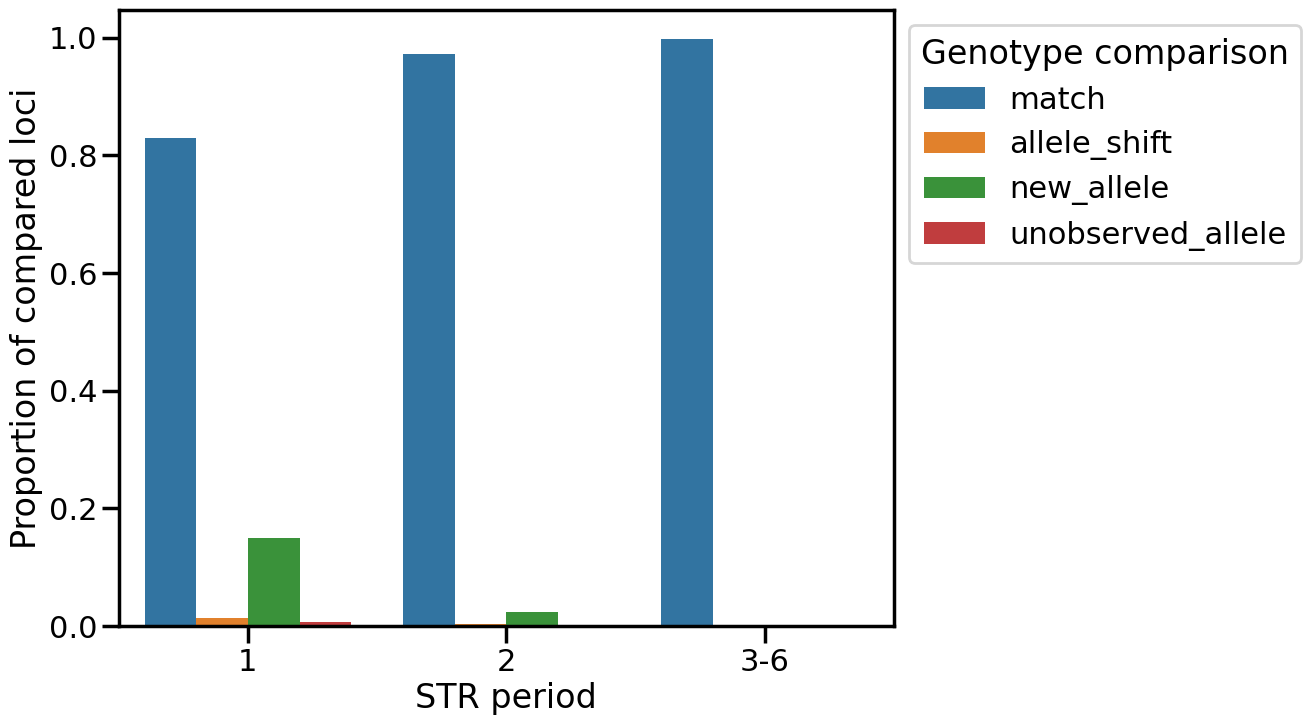

In [320]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    data = df_plot,
    x="period",
    y="proportion",
    hue="genotype_match"
)

_ = ax.get_legend().set(
    bbox_to_anchor=(1, 1),
    title="Genotype comparison"
)

_ = ax.set(
    xlabel="STR period",
    ylabel="Proportion of compared loci"
)

In [327]:
df_muts

,str_id,copy_number,frequencies_LMO,genotype_LMO,depth_LMO,depth_norm_LMO,frequencies_05_0,genotype_05_0,depth_05_0,depth_norm_05_0,period,unit,match,new_allele,unobserved_allele
0,chr1_2207909,2,"{20: 7, 21: 16, 22: 11, 23: 7}","[21, 22]",41,20.5,"{20: 2, 21: 14, 23: 17}","[21, 23]",33,16.5,2,GT,False,True,False
1,chr1_2345829,2,"{11: 2, 12: 31, 13: 12}","[12, 13]",45,22.5,"{11: 2, 12: 41}","[12, 12]",43,21.5,2,CA,False,True,True
2,chr1_2609034,2,"{16: 2, 17: 14, 18: 3, 19: 8, 20: 6}","[17, 19]",33,16.5,"{16: 1, 17: 12, 18: 9, 19: 5, 20: 2}","[17, 18]",29,14.5,2,AC,False,True,False
3,chr1_8563343,2,"{7: 5, 8: 27}","[8, 8]",32,16.0,"{6: 2, 7: 14, 8: 8}","[7, 8]",24,12.0,2,AG,False,True,False
4,chr1_9113956,2,"{16: 2, 17: 12, 18: 1, 20: 1, 21: 3, 22: 4, 23...","[17, 22]",24,12.0,"{16: 3, 17: 7, 18: 2, 19: 1, 20: 1, 21: 6, 22: 2}","[17, 21]",22,11.0,2,AC,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,chrX_144736973,2,"{15: 1, 16: 8, 17: 2, 19: 6}","[16, 19]",17,8.5,"{16: 12, 18: 3}","[16, 16]",15,7.5,3,AAT,False,True,True
3751,chrX_144775991,2,"{0: 3, 5: 12}","[5, 5]",15,7.5,"{0: 4, 5: 10}","[0, 5]",14,7.0,3,GTT,False,True,False
3752,chrX_147513148,2,"{2: 12, 3: 9}","[2, 3]",21,10.5,"{2: 4, 3: 18, 7: 2}","[3, 3]",24,12.0,6,TTGTAA,False,True,False
3753,chrX_152746276,2,"{9: 1, 10: 26, 11: 14}","[10, 11]",41,20.5,"{9: 1, 10: 31, 11: 2, 12: 14}","[10, 12]",48,24.0,4,TCTA,False,True,False


In [339]:
df_muts = pd.concat([
    # df_comp_2n.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10 and not match"),
    # df_comp_2n.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10 and not match"),
    df_comp_2n.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_05_0 >= 5 and not match"),
]).reset_index(drop=True)

print(df_comp_2n.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_05_0 >= 5").shape)
print(df_muts.shape)
print(df_muts.query("unobserved_allele").shape)
df_muts.sample(20, random_state=42)

(610546, 15)
(1625, 15)
(114, 15)


,str_id,copy_number,frequencies_LMO,genotype_LMO,depth_LMO,depth_norm_LMO,frequencies_05_0,genotype_05_0,depth_05_0,depth_norm_05_0,period,unit,match,new_allele,unobserved_allele
135,chr10_25727821,2,"{7: 15, 10: 21}","[7, 10]",36,18.000000,"{7: 7, 10: 24}","[10, 10]",31,15.500000,5,TTTTG,False,True,False
481,chr17_26952498,3,"{4: 6, 5: 36}","[5, 5, 5]",42,14.000000,"{4: 6, 5: 21}","[4, 5, 5]",27,9.000000,4,AAGG,False,True,False
836,chr3_57346537,2,"{4: 15, 5: 21}","[4, 5]",36,18.000000,"{4: 3, 5: 11}","[5, 5]",14,7.000000,3,AAC,False,True,False
1227,chr7_82222908,2,"{5: 5, 6: 10}","[5, 6]",15,7.500000,"{5: 3, 6: 26}","[6, 6]",29,14.500000,4,TTTG,False,True,False
629,chr2_89190914,2,"{8: 13, 11: 13, 12: 1}","[8, 11]",27,13.500000,"{8: 5, 10: 1, 11: 23}","[11, 11]",29,14.500000,4,TTAT,False,True,False
1169,chr6_159538182,2,"{0: 6, 3: 22, 4: 2}","[3, 3]",30,15.000000,"{0: 12, 3: 15, 4: 3}","[0, 3]",30,15.000000,5,AAGGA,False,True,False
1594,chrX_102255842,2,"{7: 27, 8: 5}","[7, 7]",32,16.000000,"{7: 18, 8: 12}","[7, 8]",30,15.000000,4,ATTC,False,True,False
816,chr3_28941938,2,{11: 35},"[11, 11]",35,17.500000,"{10: 12, 11: 13}","[10, 11]",25,12.500000,3,TAT,False,True,True
926,chr4_68236915,2,"{12: 12, 13: 26}","[12, 13]",38,19.000000,"{12: 2, 13: 28}","[13, 13]",30,15.000000,3,ATT,False,True,False
271,chr12_34629505,2,"{12: 10, 13: 21}","[12, 13]",31,15.500000,"{12: 1, 13: 26}","[13, 13]",27,13.500000,3,TTA,False,True,False


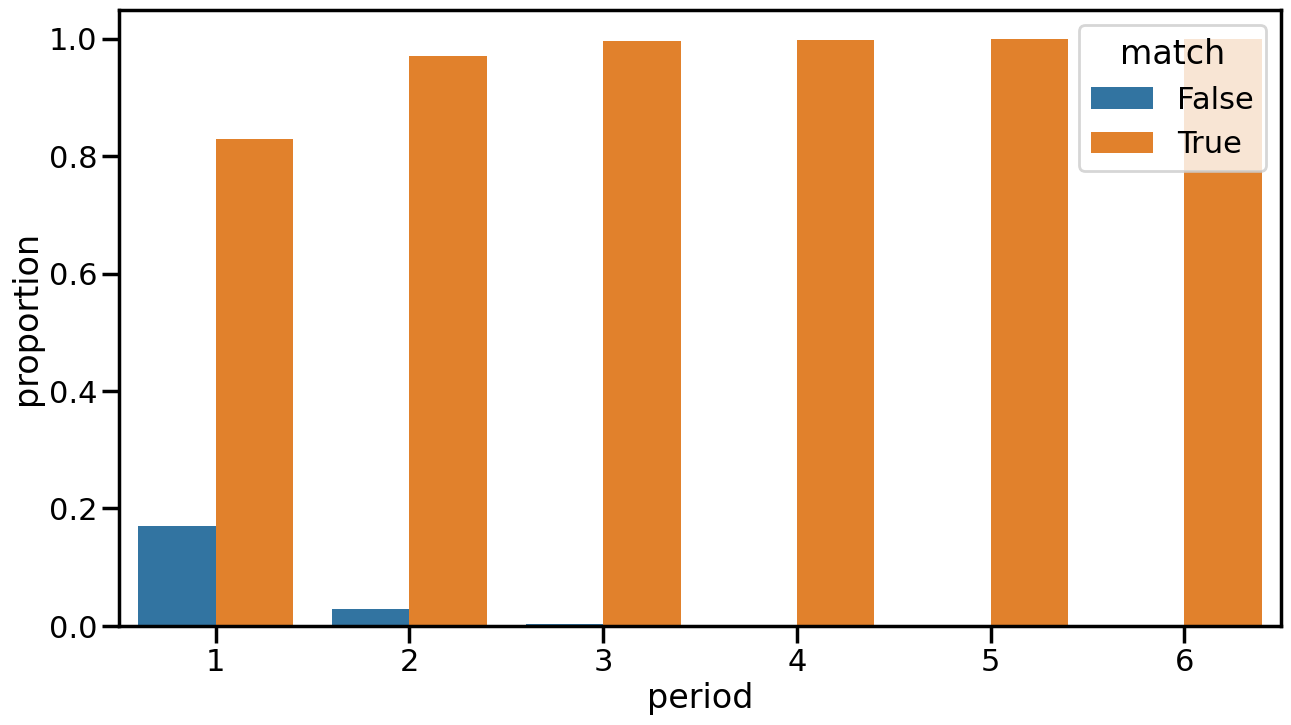

In [307]:
fig = plt.figure(figsize = (15, 8))

q = "period <= 6 and depth_norm_LMO >= 10 and depth_norm_05_0 >= 10"

ax = sns.barplot(
    data = df_comp_2n.query(q).groupby("period", as_index=False).value_counts(["match"], normalize=True),
    x = "period",
    # y = "count",
    y = "proportion",
    hue = "match"
)

## 4n samples comparison

In [249]:
df_comp_4n = (df_01_0_filt
             .merge(df_07_0_filt,
                    on=["str_id", "copy_number"],
                    suffixes=("_01_0", "_07_0"),
                    how="inner")
             .merge(df_strs[["str_id", "period", "unit"]], on="str_id"))
df_comp_4n

,str_id,copy_number,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit
0,chr1_16619,5,"{3: 2, 4: 55}","[4, 4, 4, 4, 4]",57,11.4,{4: 48},"[4, 4, 4, 4, 4]",48,9.6,3,GCT
1,chr1_22811,5,{2: 32},"[2, 2, 2, 2, 2]",32,6.4,{2: 28},"[2, 2, 2, 2, 2]",28,5.6,5,AGGAA
2,chr1_26453,5,{6: 41},"[6, 6, 6, 6, 6]",41,8.2,{6: 49},"[6, 6, 6, 6, 6]",49,9.8,2,GT
3,chr1_31555,5,{3: 19},"[3, 3, 3, 3, 3]",19,3.8,"{2: 2, 3: 33}","[3, 3, 3, 3, 3]",35,7.0,5,AAAAT
4,chr1_31719,5,"{10: 17, 11: 9, 12: 6}","[10, 10, 10, 11, 12]",32,6.4,"{10: 25, 11: 7, 12: 8, 14: 1}","[10, 10, 10, 11, 12]",41,8.2,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...
1542084,chrY_56885930,5,{4: 46},"[4, 4, 4, 4, 4]",46,9.2,{4: 57},"[4, 4, 4, 4, 4]",57,11.4,4,TAAA
1542085,chrY_56886095,5,"{9: 1, 11: 31}","[11, 11, 11, 11, 11]",32,6.4,"{10: 2, 11: 30, 14: 1}","[11, 11, 11, 11, 11]",33,6.6,1,A
1542086,chrY_56886167,5,{3: 32},"[3, 3, 3, 3, 3]",32,6.4,{3: 34},"[3, 3, 3, 3, 3]",34,6.8,4,GAAA
1542087,chrY_56886703,5,{3: 61},"[3, 3, 3, 3, 3]",61,12.2,{3: 61},"[3, 3, 3, 3, 3]",61,12.2,4,AATG


In [250]:
match, new, unobs = find_new_alleles(df_comp_4n, ("_01_0", "_07_0"))
df_comp_4n["match"] = match
df_comp_4n["new_allele"] = new
df_comp_4n["unobserved_allele"] = unobs
df_comp_4n

,str_id,copy_number,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
0,chr1_16619,5,"{3: 2, 4: 55}","[4, 4, 4, 4, 4]",57,11.4,{4: 48},"[4, 4, 4, 4, 4]",48,9.6,3,GCT,True,False,False
1,chr1_22811,5,{2: 32},"[2, 2, 2, 2, 2]",32,6.4,{2: 28},"[2, 2, 2, 2, 2]",28,5.6,5,AGGAA,True,False,False
2,chr1_26453,5,{6: 41},"[6, 6, 6, 6, 6]",41,8.2,{6: 49},"[6, 6, 6, 6, 6]",49,9.8,2,GT,True,False,False
3,chr1_31555,5,{3: 19},"[3, 3, 3, 3, 3]",19,3.8,"{2: 2, 3: 33}","[3, 3, 3, 3, 3]",35,7.0,5,AAAAT,True,False,False
4,chr1_31719,5,"{10: 17, 11: 9, 12: 6}","[10, 10, 10, 11, 12]",32,6.4,"{10: 25, 11: 7, 12: 8, 14: 1}","[10, 10, 10, 11, 12]",41,8.2,1,A,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542084,chrY_56885930,5,{4: 46},"[4, 4, 4, 4, 4]",46,9.2,{4: 57},"[4, 4, 4, 4, 4]",57,11.4,4,TAAA,True,False,False
1542085,chrY_56886095,5,"{9: 1, 11: 31}","[11, 11, 11, 11, 11]",32,6.4,"{10: 2, 11: 30, 14: 1}","[11, 11, 11, 11, 11]",33,6.6,1,A,True,False,False
1542086,chrY_56886167,5,{3: 32},"[3, 3, 3, 3, 3]",32,6.4,{3: 34},"[3, 3, 3, 3, 3]",34,6.8,4,GAAA,True,False,False
1542087,chrY_56886703,5,{3: 61},"[3, 3, 3, 3, 3]",61,12.2,{3: 61},"[3, 3, 3, 3, 3]",61,12.2,4,AATG,True,False,False


In [268]:
print(df_comp_4n.value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp_4n.query("not match").value_counts(["new_allele"], normalize=True))
print()
print(df_comp_4n.query("new_allele").value_counts(["unobserved_allele"], normalize=True))

match  new_allele  unobserved_allele
True   False       False                0.716439
False  True        False                0.145880
       False       False                0.114953
       True        True                 0.022728
Name: proportion, dtype: float64

new_allele
True          0.594611
False         0.405389
Name: proportion, dtype: float64

unobserved_allele
False                0.865201
True                 0.134799
Name: proportion, dtype: float64


In [313]:
print(df_comp_4n.query("period == 1 and depth_norm_01_0 >= 10 and depth_norm_07_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp_4n.query("period == 2 and depth_norm_01_0 >= 10 and depth_norm_07_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp_4n.query("period > 2 and depth_norm_01_0 >= 10 and depth_norm_07_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))


match  new_allele  unobserved_allele
True   False       False                0.568436
False  True        False                0.210352
       False       False                0.198227
       True        True                 0.022985
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.953750
False  False       False                0.034375
       True        False                0.009062
                   True                 0.002812
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.994530
False  False       False                0.004768
       True        False                0.000665
                   True                 0.000037
Name: proportion, dtype: float64


In [264]:
df_comp_4n.query("unobserved_allele and period >= 1 and copy_number == 4 and depth_norm_01_0 >= 10 and depth_norm_07_0 >= 10").tail(20)
# df_comp_4n.query("unobserved_allele and period > 2 and copy_number == 4").head(20)

,str_id,copy_number,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
1455733,chr9_123600830,4,"{8: 11, 9: 31, 11: 1}","[8, 9, 9, 9]",43,10.75,{9: 41},"[9, 9, 9, 9]",41,10.25,1,A,False,True,True
1456030,chr9_124056705,4,"{10: 1, 12: 1, 13: 3, 14: 16, 15: 13, 16: 7}","[14, 14, 15, 16]",41,10.25,"{12: 2, 13: 1, 14: 19, 15: 20, 17: 1}","[14, 14, 15, 15]",43,10.75,1,A,False,True,True
1457071,chr9_125311724,4,"{10: 1, 11: 24, 12: 2, 15: 11, 16: 2}","[11, 11, 11, 15]",40,10.00,"{9: 2, 11: 20, 12: 2, 13: 3, 15: 13, 16: 2}","[11, 11, 13, 15]",42,10.50,1,T,False,True,True
1457184,chr9_125449930,4,"{8: 11, 9: 31}","[8, 9, 9, 9]",42,10.50,"{9: 43, 10: 3}","[9, 9, 9, 9]",46,11.50,1,T,False,True,True
1457919,chr9_126681900,4,"{10: 1, 11: 24, 12: 25}","[11, 11, 12, 12]",50,12.50,"{11: 21, 12: 14, 13: 7}","[11, 11, 12, 13]",42,10.50,1,A,False,True,True
1458159,chr9_127008140,4,{11: 41},"[11, 11, 11, 11]",41,10.25,"{9: 2, 10: 9, 11: 28, 12: 1}","[10, 11, 11, 11]",40,10.00,1,A,False,True,True
1458732,chr9_127830340,4,"{10: 1, 11: 5, 12: 23, 13: 13, 18: 1}","[11, 12, 12, 13]",43,10.75,"{11: 2, 12: 20, 13: 11, 14: 5, 15: 1, 16: 1, 1...","[12, 12, 13, 14]",41,10.25,1,A,False,True,True
1458935,chr9_128070257,4,"{9: 15, 10: 36}","[9, 10, 10, 10]",51,12.75,{10: 45},"[10, 10, 10, 10]",45,11.25,1,T,False,True,True
1459129,chr9_128304720,4,"{8: 8, 9: 32}","[8, 9, 9, 9]",40,10.00,{9: 41},"[9, 9, 9, 9]",41,10.25,1,T,False,True,True
1459302,chr9_128474964,4,"{9: 1, 10: 2, 11: 12, 12: 25, 13: 5}","[11, 12, 12, 13]",45,11.25,"{11: 15, 12: 27}","[11, 12, 12, 12]",42,10.50,1,A,False,True,True


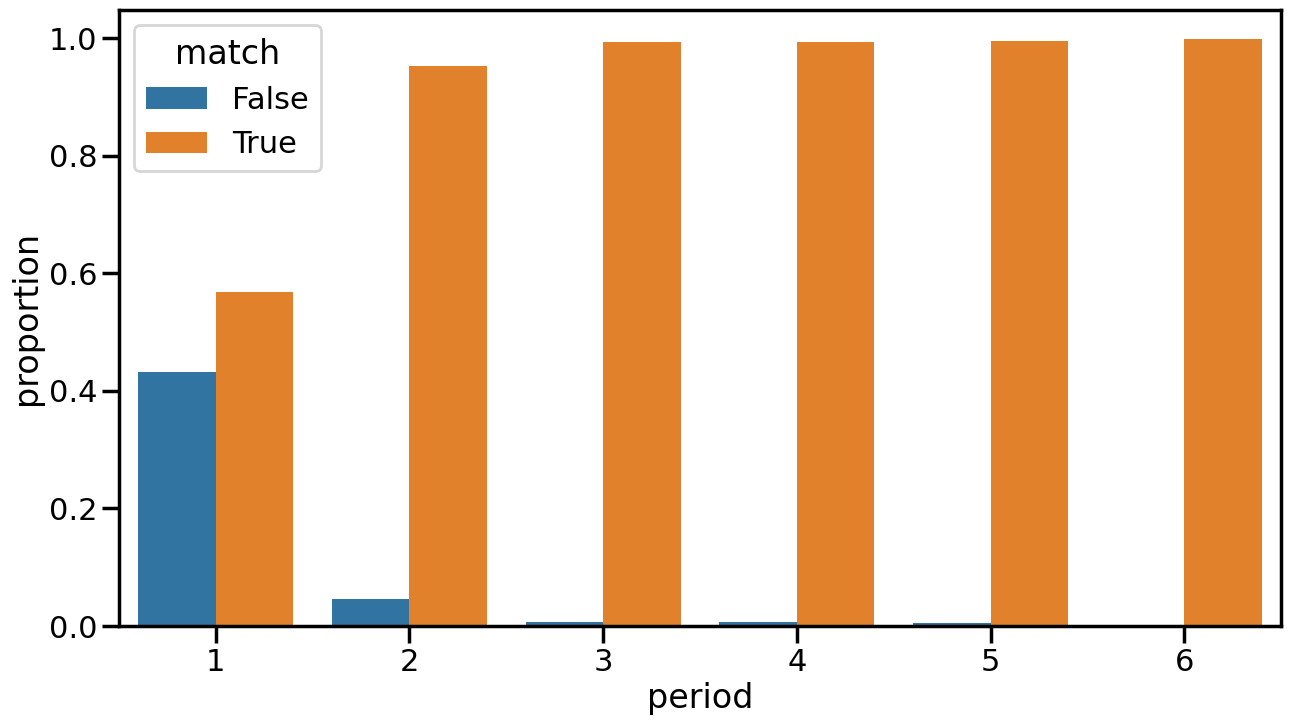

In [305]:
fig = plt.figure(figsize = (15, 8))

q = "period <= 6 and depth_norm_01_0 >= 10 and depth_norm_07_0 >= 10"

ax = sns.barplot(
    data = df_comp_4n.query(q).groupby("period", as_index=False).value_counts(["match"], normalize=True),
    x = "period",
    # y = "count",
    y = "proportion",
    hue = "match"
)

## Some stats?

In [280]:
print(df_comp_2n.value_counts(["new_allele"]))
print(df_comp_4n.value_counts(["new_allele"]))

new_allele
False         1369038
True           133055
Name: count, dtype: int64
new_allele
False         1282080
True           260009
Name: count, dtype: int64


In [286]:
print(df_comp_2n.value_counts(["new_allele"]))
print(df_comp_4n.value_counts(["new_allele"], normalize=True))

new_allele
False         0.91142
True          0.08858
Name: proportion, dtype: float64
new_allele
False         0.831392
True          0.168608
Name: proportion, dtype: float64


In [283]:
from scipy import stats

obs = np.array([[1369038, 133055], [1282080, 260009]])

stats.chi2_contingency(obs)

Chi2ContingencyResult(statistic=43337.85782226532, pvalue=0.0, dof=1, expected_freq=array([[1308143.13663703,  193949.86336297],
       [1342974.86336297,  199114.13663703]]))

In [291]:
print(df_comp_2n.query("not match").value_counts(["unobserved_allele"]))
print(df_comp_4n.query("not match").value_counts(["unobserved_allele"]))

unobserved_allele
False                139311
True                   5584
Name: count, dtype: int64
unobserved_allele
False                402227
True                  35049
Name: count, dtype: int64


In [292]:
print(df_comp_2n.query("not match").value_counts(["unobserved_allele"], normalize=True))
print(df_comp_4n.query("not match").value_counts(["unobserved_allele"], normalize=True))

unobserved_allele
False                0.961462
True                 0.038538
Name: proportion, dtype: float64
unobserved_allele
False                0.919847
True                 0.080153
Name: proportion, dtype: float64


In [295]:
obs = np.array([[139311, 5584], [402227, 35049]])

stats.chi2_contingency(obs)

Chi2ContingencyResult(statistic=2902.359663256044, pvalue=0.0, dof=1, expected_freq=array([[134781.96012855,  10113.03987145],
       [406756.03987145,  30519.96012855]]))